In [27]:
import numpy as np
import os
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
%matplotlib inline

In [135]:
from importlib import reload
import naive_keras
reload(naive_keras)
from naive_keras import Sequential, Conv2D, MaxPooling2D, ZeroPadding2D

In [103]:
model = Sequential(Conv2D(5, input_shape=(None, 20, 20, 3)),
                    MaxPooling2D(),
                    ZeroPadding2D(),
                    Conv2D(5))

In [4]:
x = np.random.randn(10,20,20,3)
y = model.predict(x)

In [5]:
model.layers[0].save_memory = True
model.layers[-1].save_memory = True
y2 = model.predict(x)

In [6]:
np.allclose(y, y2)

True

In [108]:
from importlib import reload
import naive_keras
reload(naive_keras)
from naive_keras import Sequential, Conv2D, MaxPooling2D, ZeroPadding2D

model = Sequential(Conv2D(5, input_shape=(None, 20, 20, 3)),
                    MaxPooling2D(),
                    ZeroPadding2D(),
                    Conv2D(5))

model.folder = '/home/spi/nbs/input/train/'

In [23]:
pics, labels = model.load_random_input(20, (56,56,3))

In [28]:
l = model.layers[0]

In [43]:
sm = l.extract_submatrices(pics)

In [44]:
sm.shape

(20, 324, 27)

In [53]:
def normalize(sm):

    mean = sm.reshape(-2,sm.shape[2]).mean(axis=0)
    std = sm.reshape(-2,sm.shape[2]).std(axis=0)
    sm = (sm - mean) / std
    return(sm)

sm = normalize(sm)

In [66]:
svm = LinearSVC()

svm.fit(sm.reshape(-1, sm.shape[2]), np.repeat(labels, 324))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [69]:
svm.score(sm.reshape(-1, sm.shape[2]), np.repeat(labels, 324))

0.64969135802469136

In [73]:
svm.predict(sm.reshape(-1, sm.shape[2]))[:20]

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [85]:
np.allclose((np.sign(sm.reshape(-1, sm.shape[2]).dot(svm.coef_.T) + svm.intercept_) + 1).flatten() // 2, svm.predict(sm.reshape(-1, sm.shape[2])))

True

In [90]:
(sm.reshape(-1, sm.shape[2])[:10].dot(svm.coef_.T) + svm.intercept_).flatten()

array([-0.1182708 , -0.03388457,  0.04741622,  0.02791344, -0.02333101,
        0.01010835, -0.02003861, -0.04512518,  0.01602263, -0.02097458])

In [88]:
svm.decision_function(sm.reshape(-1, sm.shape[2])[:10])

array([-0.1182708 , -0.03388457,  0.04741622,  0.02791344, -0.02333101,
        0.01010835, -0.02003861, -0.04512518,  0.01602263, -0.02097458])

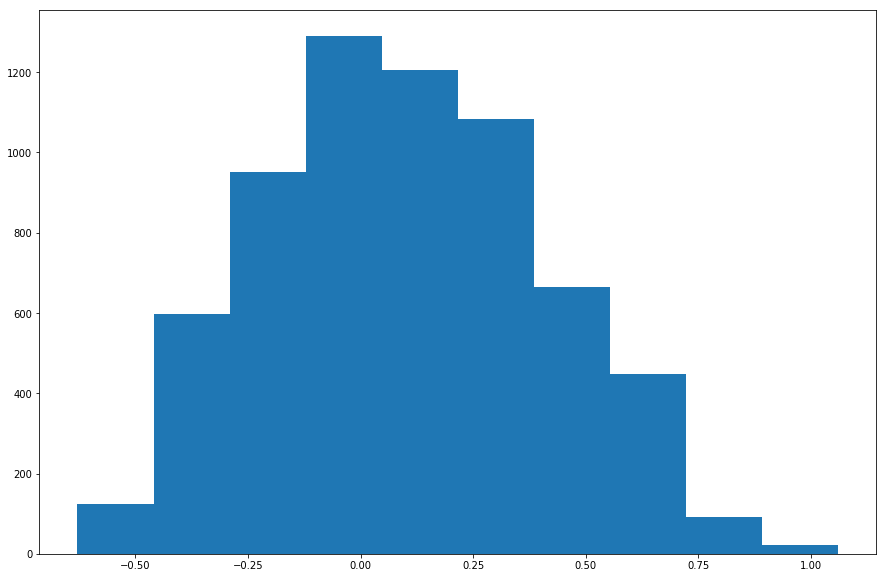

In [94]:
plt.figure(figsize=(15,10))
plt.hist(svm.decision_function(sm.reshape(-1, sm.shape[2])))
plt.show()

In [137]:

model = Sequential(Conv2D(20, input_shape=(None, 20, 20, 3)),
                    MaxPooling2D(),
                    ZeroPadding2D(),
                    Conv2D(5))


model.folder = '/home/spi/nbs/input/train/'

l = model.layers[0]
svms = []
batch_size=10
input_shape = l.input_shape
for f in range(l.filters):

    pics, labels = model.load_random_input(batch_size, input_shape[1:], normalize=True)
    if len(set(labels)) != 2:
        raise NameError('For the moment, only 2 classes case is implemented...')

    # For the moment, only do the version "without memory saving"

    # Predict up to l (excluding) and take all the submatrices.
    sm = l.extract_submatrices(model.predict(pics, until_layer=l))
    reshaped = sm.reshape(-1, sm.shape[2])

    # If it is not the first filter, give weight < 1 if a previous SVM already
    # classifies it more or less correctly.
    sample_weights = np.ones(reshaped.shape[0])

    svm_labels = np.repeat(labels, sm.shape[1])
    svm_labels[svm_labels == 0] = -1
    for i in range(len(svms)):
        sample_weights = np.minimum(sample_weights, 1-np.maximum(svms[i].decision_function(reshaped) * svm_labels, 0))

    print('Round {} of {}: {:.1f}% of the weights used'.format(f, l.filters, np.mean(sample_weights)*100))

    svms.append(LinearSVC())
    # Fit the (Linear) support vector machine on all the submatrices; so we need to repeat the label quite a bit.
    svms[-1].fit(reshaped, np.repeat(labels, sm.shape[1]), sample_weight = sample_weights)


Round 0 of 20: 100.0% of the weights used
Round 1 of 20: 88.3% of the weights used
Round 2 of 20: 92.2% of the weights used
Round 3 of 20: 66.0% of the weights used
Round 4 of 20: 71.4% of the weights used
Round 5 of 20: 43.8% of the weights used
Round 6 of 20: 48.6% of the weights used
Round 7 of 20: 52.0% of the weights used
Round 8 of 20: 44.2% of the weights used
Round 9 of 20: 39.7% of the weights used
Round 10 of 20: 47.0% of the weights used
Round 11 of 20: 43.2% of the weights used
Round 12 of 20: 43.2% of the weights used
Round 13 of 20: 46.6% of the weights used
Round 14 of 20: 40.2% of the weights used
Round 15 of 20: 44.1% of the weights used
Round 16 of 20: 38.8% of the weights used
Round 17 of 20: 37.9% of the weights used
Round 18 of 20: 40.5% of the weights used
Round 19 of 20: 33.8% of the weights used


In [141]:
from importlib import reload
import naive_keras
reload(naive_keras)
from naive_keras import Sequential, Conv2D, MaxPooling2D, ZeroPadding2D

model = Sequential(Conv2D(20, input_shape=(None, 20, 20, 3)),
                    MaxPooling2D(),
                    ZeroPadding2D(),
                    Conv2D(5))

model.folder = '/home/spi/nbs/input/train/'

model.initialize_layer_by_SVM(model.layers[0], batch_size=100)

Round 0 of 20: 100.0% of the weights used
Round 1 of 20: 97.8% of the weights used
Round 2 of 20: 96.1% of the weights used
Round 3 of 20: 86.8% of the weights used
Round 4 of 20: 80.4% of the weights used
Round 5 of 20: 78.3% of the weights used
Round 6 of 20: 72.7% of the weights used
Round 7 of 20: 67.6% of the weights used
Round 8 of 20: 64.1% of the weights used
Round 9 of 20: 59.1% of the weights used
Round 10 of 20: 57.0% of the weights used
Round 11 of 20: 57.2% of the weights used
Round 12 of 20: 55.4% of the weights used
Round 13 of 20: 56.7% of the weights used
Round 14 of 20: 56.3% of the weights used
Round 15 of 20: 47.9% of the weights used
Round 16 of 20: 43.3% of the weights used
Round 17 of 20: 45.1% of the weights used
Round 18 of 20: 42.7% of the weights used
Round 19 of 20: 43.3% of the weights used


In [128]:
1-np.maximum(svms[i].decision_function(reshaped) * svm_labels, 0)

ValueError: operands could not be broadcast together with shapes (3240,) (10,) 

In [130]:
labels

array([ 1, -1, -1,  1, -1, -1, -1,  1, -1, -1])